In [1]:
import numpy as np
import scipy
from activ import load_data
from activ.readfile import load_preprocessed, TrackTBIFile, encode
from activ.data_normalization import data_normalization
import pandas as pd
from sklearn import preprocessing
from collections import Counter
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs, make_regression
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl
import os
from activ.analytics import conf_alliter, accuracy, plot_clustering_results_activ_data, plot_clustering_results
from scipy.optimize import curve_fit
from umap import UMAP
from activ.clustering import bootstrapped_umap_clustering
from sklearn.ensemble import RandomForestClassifier as RFC
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, cut_tree

In [2]:
def sim_data_2000(n):
    rand = np.random.RandomState(1)
    X, classes = make_blobs(n_samples=2000, n_features=235, centers=n, random_state=rand)
    beta = rand.normal(size=(235,177))
    error = rand.normal(size=(2000,177))
    Y = X @ beta + error
    TrackTBIFile.write('/Users/ahyeon/data/activ/sim_data_{}_blobs_2000_samples.h5'.format(n), X, Y)

In [6]:
def sim_data(n):
    rand = np.random.RandomState(1)
    X, classes = make_blobs(n_samples=247, n_features=235, centers=n, random_state=rand)
    beta = rand.normal(size=(235,177))
    error = rand.normal(size=(247,177))
    Y = X @ beta + error
    TrackTBIFile.write('/Users/ahyeon/data/activ/sim_data_{}_blobs.h5'.format(n), X, Y)

In [14]:
def reg_data():
    rand = np.random.RandomState(1)
    X, y = make_regression(n_samples=247, n_features=235, n_informative=235, effective_rank=10)
    beta = rand.normal(size=(235,177))
    error = rand.normal(size=(247,177))
    Y = X @ beta + error
    TrackTBIFile.write('/Users/ahyeon/data/activ/reg_data.h5', X, Y)


In [3]:
blobs = [5,10,15,20,25,30]
for b in blobs:
    sim_data_2000(b)

In [15]:
reg_data()

/Users/ahyeon/Desktop/activ/activ/analytics.py:279: RuntimeWarning: divide by zero encountered in double_scalars
  foc = [float(x/y) for x, y in zip(acc, norm_acc)]


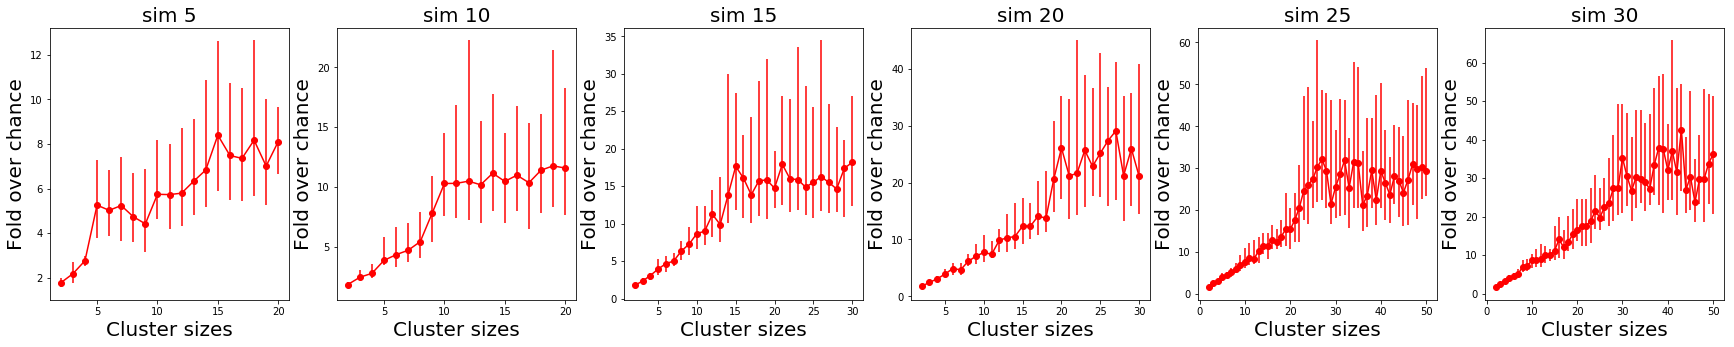

In [4]:
# run_umap pipeline

num = [5,10,15,20,25,30]
fig1 = plt.figure(figsize=(30,5))
for j,n in zip(range(6), num):
    fig1.add_subplot(1, 6, j+1)
    plot_clustering_results_activ_data('simdata/sim_{}'.format(n), 'foc', specific_plot_name='sim {}'.format(n))
plt.savefig('/Users/ahyeon/Desktop/activ misc/fig1.png')
plt.show()

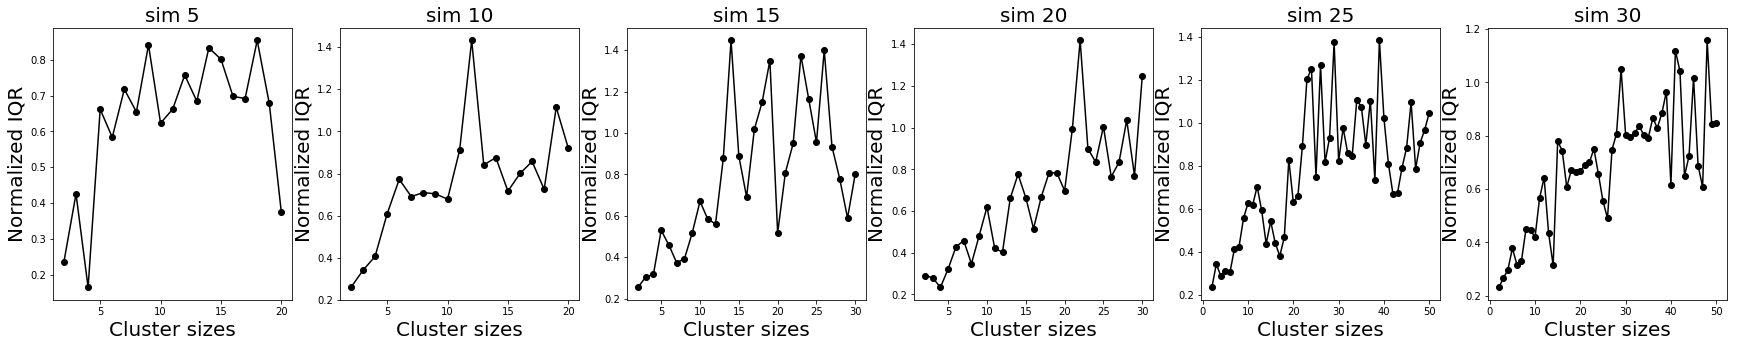

In [5]:
# run umap pipeline

fig2 = plt.figure(figsize=(30,5))
for j,n in zip(range(6), num):
    fig2.add_subplot(1, 6, j+1)
    plot_clustering_results_activ_data('simdata/sim_{}'.format(n), 'iqr', specific_plot_name='sim {}'.format(n))
plt.savefig('/Users/ahyeon/Desktop/activ misc/fig2.png')
plt.show()

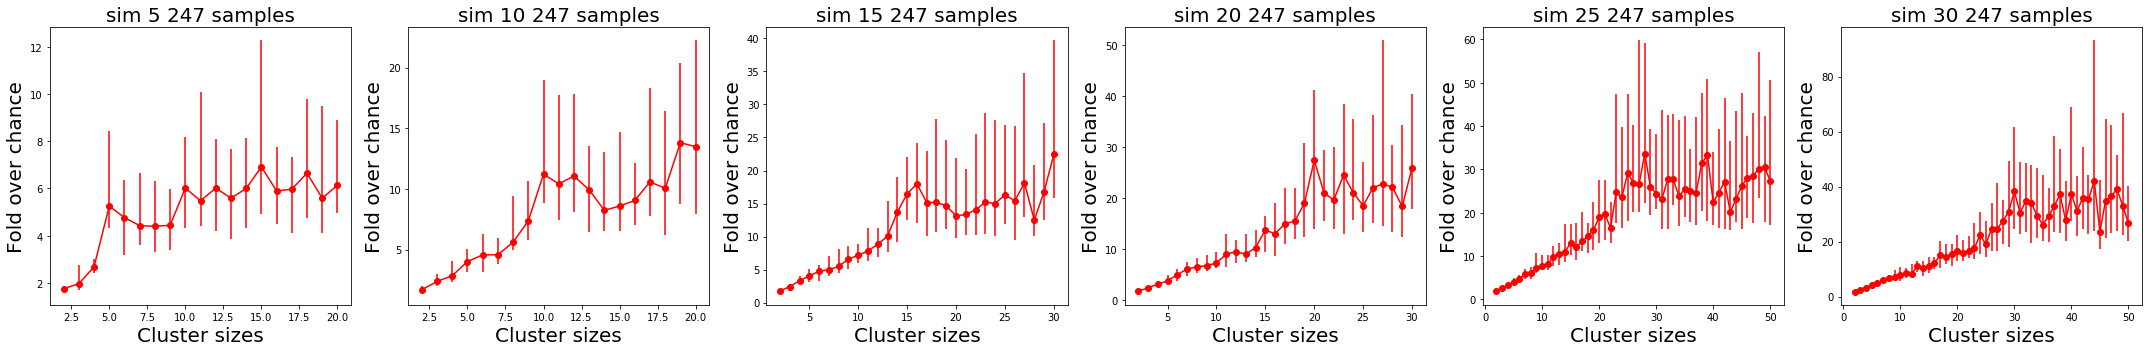

In [12]:
# original pipeline, transformed sim data, 247 subjects

num = [5,10,15,20,25,30]
fig1 = plt.figure(figsize=(30,5))
for j,n in zip(range(6), num):
    fig1.add_subplot(1, 6, j+1)
    path = '/Users/ahyeon/Desktop/activ_misc/sim_{}_transformed_247_samples_original_cluster_results.h5'.format(n)
    plot_clustering_results(path, 'foc', specific_plot_name='sim {} 247 samples'.format(n))
plt.tight_layout()
plt.savefig('/Users/ahyeon/Desktop/activ_misc/sim_data_transformed_247_samples.png')
plt.show()

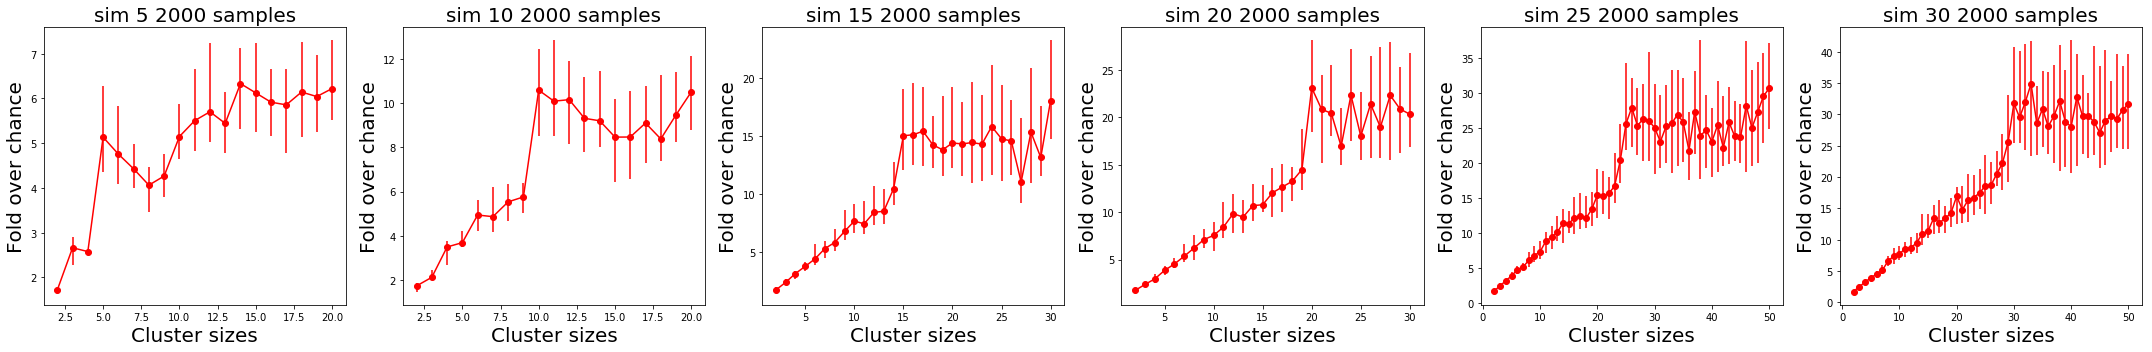

In [37]:
# original pipeline, transformed sim data, 2000 subjects

num = [5,10,15,20,25,30]
fig1 = plt.figure(figsize=(30,5))
for j,n in zip(range(6), num):
    fig1.add_subplot(1, 6, j+1)
    path = '/Users/ahyeon/Desktop/activ_misc/sim_{}_transformed_2000_samples_original_cluster_results.h5'.format(n)
    plot_clustering_results(path, 'foc', specific_plot_name='sim {} 2000 samples'.format(n))
plt.tight_layout()
plt.savefig('/Users/ahyeon/Desktop/activ_misc/sim_data_transformed_2000_samples.png')
plt.show()

In [6]:
import PIL
list_im = ['/Users/ahyeon/Desktop/activ misc/fig1.png', '/Users/ahyeon/Desktop/activ misc/fig2.png']
imgs    = [ PIL.Image.open(i) for i in list_im ]
imgs_comb = np.vstack(i for i in imgs) 
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb

def func(x, a, b, c):
    return (a * np.exp(-b * x)) + imgs_comb.save('/Users/ahyeon/Desktop/activ misc/sim_foc_iqr.png', bbox_inches='tight')

In [35]:
path = '/Users/ahyeon/Desktop/activ_misc/sim_30_transformed_2000_samples_original_cluster_results.h5'
with h5py.File(path,'r') as f:
    predictions = np.squeeze(f['score'][:], axis=1)
    print(predictions.shape)
    norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
    cluster_sizes = f['cluster_sizes'][:]
    labels = np.squeeze(f['clusters'][:], axis=1)
    num_iter = predictions.shape[0]
    num_clust = len(cluster_sizes)
    fold_over_chance = np.zeros((num_clust, num_iter))
    raw_acc = np.zeros((num_clust, num_iter))
    normalized_acc = np.zeros((num_clust, num_iter))
    for jj,c in enumerate(cluster_sizes):
        all50mat = conf_alliter(c, predictions, labels, num_iter)
        norm_all50mat = conf_alliter(c, norm_predictions, labels, num_iter)
        acc = [accuracy(i) for i in all50mat]
        norm_acc = [accuracy(i) for i in norm_all50mat]
        foc = [float(x/y) for x, y in zip(acc, norm_acc)]
        fold_over_chance[jj,:] = foc
        raw_acc[jj,:] = acc
        normalized_acc[jj,:] = norm_acc

OSError: Unable to open file (unable to open file: name = '/Users/ahyeon/Desktop/activ_misc/sim_30_transformed_2000_samples_original_cluster_results.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [27]:
from numpy import inf
fold_over_chance[fold_over_chance == inf] = 0

In [28]:
np.mean(fold_over_chance, axis=1)

array([ 1.75443265,  2.42176867,  3.06598317,  3.97097211,  4.82636073,
        5.74776016,  6.48326831,  7.29330413,  7.62957415,  9.48782874,
       10.16247712,  9.93335279, 11.32384662, 11.79463664, 12.52264055,
       13.3106829 , 13.41427614, 16.15658476, 23.46388961, 22.07004597,
       22.49473214, 20.41076094, 22.92295366, 19.88868136, 21.66981367,
       22.37234121, 23.400378  , 21.99015683, 22.64160891])

In [32]:
def func(x, a, b, c):
    return (a * np.exp(-b * x)) + c

def plot_optimal_k(data, name):
    yvar = np.var(data, axis=1)
    ydata = np.mean(data, axis=1)
    popt, pcov = curve_fit(func, cluster_sizes, ydata, p0 = [1000,1,3])
    yval = func(cluster_sizes, *popt) 
    y = ydata
    plt.figure(figsize=(10,10))
    plt.plot(cluster_sizes, ydata, label='data', color='black')
    plt.plot(cluster_sizes, yval, '--',label='fit', color='red')
    plt.plot(cluster_sizes, [popt[2]]*len(cluster_sizes), '--', color='grey', label='asymptote')

    shift = 1.96*np.sqrt(yvar)
    grey_shift = 1.96*np.sqrt(pcov[2][2])
    optimal_k = np.where([popt[2]]*len(cluster_sizes)-grey_shift-(y+shift) <0)[0][0]+2
    plt.axvline(optimal_k, label='optimal k')
    plt.fill_between(cluster_sizes, y+shift, y-shift, alpha = 0.2, color='pink')
    plt.fill_between(cluster_sizes, [popt[2]]*len(cluster_sizes)+grey_shift, [popt[2]]*len(cluster_sizes)-grey_shift, alpha = 0.2, color='grey')

    plt.xlabel('Cluster Number', fontsize=16)
    plt.ylabel('Fold over Chance', fontsize=16)
    plt.title('{} vs Cluster Number\nk={}'.format(name, optimal_k), fontsize=20)
    plt.legend()

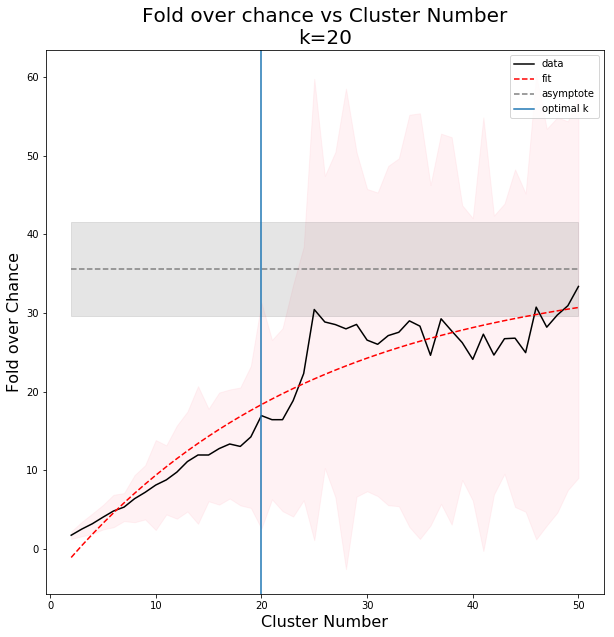

In [33]:
plot_optimal_k(fold_over_chance, 'Fold over chance')